Τιμές των μεταβλητών yy:
a (μετοχή): 1.1132388663967612
b (ρευστό): -0.0
Call options: [ 2.96761134  0.         -3.9808502 ]
Put options: [ 0.         -5.93522267  7.04846154]
Maximum possible loss (D): -100.0
portfolio_value: 182.00000000000003


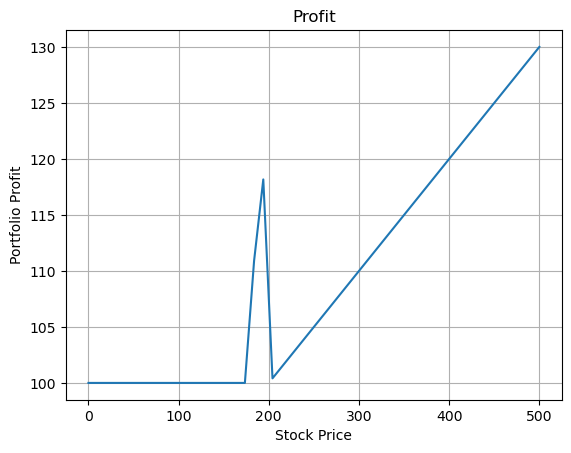


Ανάλυση ευαισθησίας...

Οπτικοποίηση αποτελεσμάτων ανάλυσης ευαισθησίας...


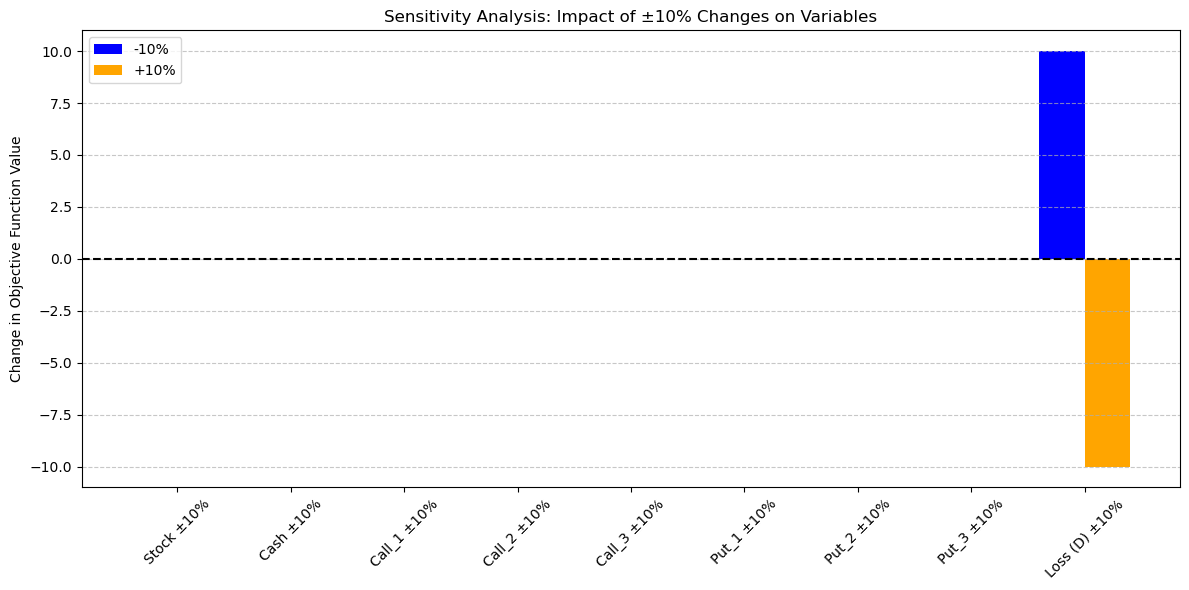

In [1]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Δεδομένα
Y = 182                             # ποσό που επενδύω
strikes = [180, 190, 200]
CK = [16.3, 12, 15]                 # τιμές call options
PL = [12.9, 17, 13]                 # τιμές put options
S0 = 182.0                          # τιμή μετοχής
RatetoInf = 0.1

num_strikes = len(strikes)

# σειρές και στήλες
num_vars = 2 + 2 * num_strikes + 1  # Μετοχή, ρευστό, call options, put options, D: loss
num_inequalities = 1 + num_strikes + 2 + 1

b = np.zeros(num_inequalities)

# βαζω το πρωτο χ=0 και μετα τις τιμες των κολ και πουτ
x_values = [0] + strikes

# Δημιουργία πίνακα A
def vectors(x):  # variables:x, strikes
    call_terms = [-np.maximum(x - K, 0) for K in strikes]
    put_terms = [-np.maximum(L - x, 0) for L in strikes]
    vectors = [-x, -1] + call_terms + put_terms + [-1]
    return vectors

A = []
for x in x_values:
    A.append(vectors(x))

A = np.array(A)

# Τελευταίες γραμμές για τον πίνακα A
A = np.vstack([A, np.array([0, -1] + [0] * (2 * num_strikes) + [0])])  # b
A = np.vstack([A, np.array([-1, 0] + [-1] * num_strikes + [0] * num_strikes + [0])])  # παραγωγός
A = np.vstack([A, np.array([0] * (2 + 2 * num_strikes) + [-1])])  # D

# Πίνακας b
b[:num_strikes + 1] = -Y
b[num_strikes + 1] = 0
b[num_strikes + 2] = -RatetoInf
b[-1] = 100  # D > -100

# eksiswsi
Aeq = np.zeros((1, num_vars))
Aeq[0, 0] = S0
Aeq[0, 1] = 1
Aeq[0, 2:2 + len(CK)] = CK
Aeq[0, 2 + len(CK):2 + len(CK) + len(PL)] = PL
Aeq[0, -1] = 0

beq = np.array([Y])

# αντικειμενική συνάρτηση
f = np.zeros(num_vars)
f[-1] = 1  # 1 στη τελευταία θέση

# Περιορισμοί
bounds = [(None, None), (None, None)] + [(None, None)] * num_strikes + [(None, None)] * num_strikes + [(None, None)]

# Επίλυση
result = linprog(f, A, b, Aeq, beq, bounds, method='highs')

# Τιμές των a,b,c....
if not result.success:
    print("Το πρόβλημα δεν έχει λύση:", result.message)
else:
    yy = result.x
    print("Τιμές των μεταβλητών yy:")
    print(f"a (μετοχή): {yy[0]}")
    print(f"b (ρευστό): {yy[1]}")
    print(f"Call options: {yy[2:2 + num_strikes]}")
    print(f"Put options: {yy[2 + num_strikes:2 + num_strikes + num_strikes]}")
    print(f"Maximum possible loss (D): {yy[-1]}")

    portfolio_value = yy[0] * S0 + yy[1] + np.sum(yy[2:2 + num_strikes] * np.array(CK)) + \
                      np.sum(yy[2 + num_strikes:2 + 2 * num_strikes] * np.array(PL))
    print(f"portfolio_value: {portfolio_value}")

    def d(x):
        call_profit = np.sum([yy[2 + i] * np.maximum(x - strikes[i], 0) for i in range(num_strikes)], axis=0)
        put_profit = np.sum([yy[2 + num_strikes + i] * np.maximum(strikes[i] - x, 0) for i in range(num_strikes)], axis=0)
        return yy[0] * x + yy[1] + call_profit + put_profit - Y

    x_values = np.linspace(0, 500)
    y_values = d(x_values)

    # Γραφική
    plt.plot(x_values, y_values)
    plt.grid(True)
    plt.title('Profit')
    plt.xlabel('Stock Price')
    plt.ylabel('Portfolio Profit')
    plt.show()

    # Ανάλυση ευαισθησίας
    print("\nΑνάλυση ευαισθησίας...")
    sensitivity_results = []
    percent_changes = [-0.1, 0.1]  # ±10% αλλαγές
    variables = ['Stock', 'Cash'] + [f'Call_{i}' for i in range(1, num_strikes + 1)] + \
                [f'Put_{i}' for i in range(1, num_strikes + 1)] + ['Loss (D)']

    for i in range(len(f)):
        results_for_var = []
        for change in percent_changes:
            f_modified = f.copy()
            f_modified[i] *= (1 + change)
            modified_result = linprog(f_modified, A, b, Aeq, beq, bounds, method='highs')
            if modified_result.success:
                results_for_var.append(modified_result.fun)
            else:
                results_for_var.append(None)
                print(f"Το πρόβλημα δεν έχει λύση όταν μεταβάλλεται η μεταβλητή {variables[i]} κατά {change * 100}%.")
        sensitivity_results.append(results_for_var)

    # Οπτικοποίηση
    print("\nΟπτικοποίηση αποτελεσμάτων ανάλυσης ευαισθησίας...")
    x_labels = [f'{var} ±10%' for var in variables]
    base_value = result.fun

    plt.figure(figsize=(12, 6))
    for i, var_results in enumerate(sensitivity_results):
        if var_results[0] is not None:
            plt.bar(i - 0.2, var_results[0] - base_value, width=0.4, color='blue', label='-10%' if i == 0 else "")
        if var_results[1] is not None:
            plt.bar(i + 0.2, var_results[1] - base_value, width=0.4, color='orange', label='+10%' if i == 0 else "")

    plt.axhline(0, color='black', linestyle='--')
    plt.xticks(range(len(variables)), x_labels, rotation=45)
    plt.ylabel('Change in Objective Function Value')
    plt.title('Sensitivity Analysis: Impact of ±10% Changes on Variables')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


Τιμές των μεταβλητών yy:
a (μετοχή): 1.1132388663967612
b (ρευστό): -0.0
Call options: [ 2.96761134  0.         -3.9808502 ]
Put options: [ 0.         -5.93522267  7.04846154]
Maximum possible loss (D): -100.0
Portfolio Value: 182.00000000000003


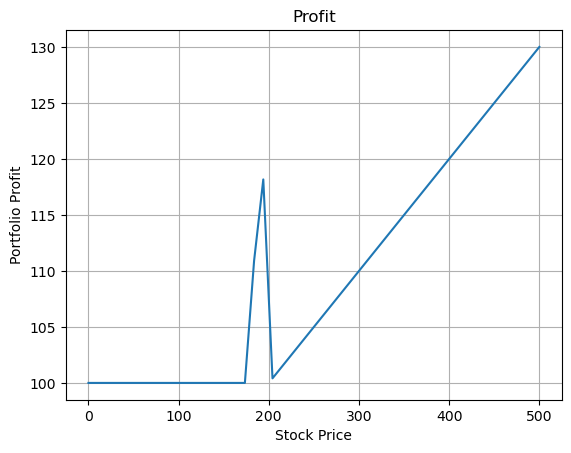


Ανάλυση ευαισθησίας στο Portfolio Value...

Ανάλυσης ευαισθησίας στο Portfolio Value...


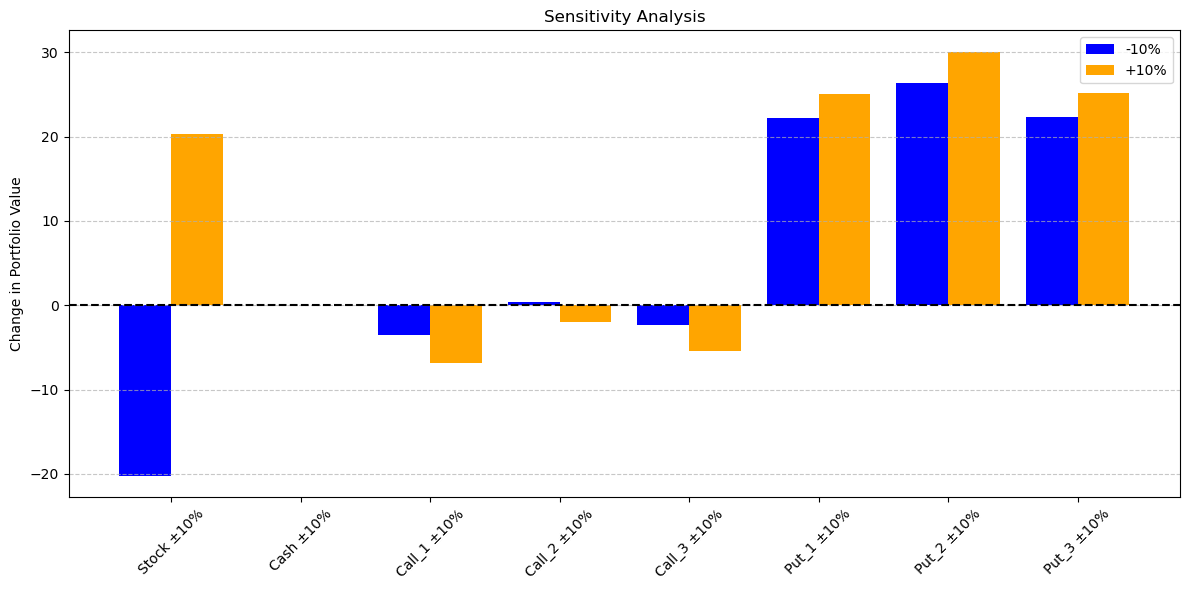

In [2]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Δεδομένα
Y = 182                             # ποσό που επενδύω
strikes = [180, 190, 200]
CK = [16.3, 12, 15]                 # τιμές call options
PL = [12.9, 17, 13]                 # τιμές put options
S0 = 182.0                          # τιμή μετοχής
RatetoInf = 0.1

num_strikes = len(strikes)

# σειρές και στήλες
num_vars = 2 + 2 * num_strikes + 1  # Μετοχή, ρευστό, call options, put options, D: loss
num_inequalities = 1 + num_strikes + 2 + 1

b = np.zeros(num_inequalities)

# βαζω το πρωτο χ=0 και μετα τις τιμες των κολ και πουτ
x_values = [0] + strikes

# Δημιουργία πίνακα A
def vectors(x):  # variables:x, strikes
    call_terms = [-np.maximum(x - K, 0) for K in strikes]
    put_terms = [-np.maximum(L - x, 0) for L in strikes]
    vectors = [-x, -1] + call_terms + put_terms + [-1]
    return vectors

A = []
for x in x_values:
    A.append(vectors(x))

A = np.array(A)

# Τελευταίες γραμμές για τον πίνακα A
A = np.vstack([A, np.array([0, -1] + [0] * (2 * num_strikes) + [0])])  # b
A = np.vstack([A, np.array([-1, 0] + [-1] * num_strikes + [0] * num_strikes + [0])])  # παραγωγός
A = np.vstack([A, np.array([0] * (2 + 2 * num_strikes) + [-1])])  # D

# Πίνακας b
b[:num_strikes + 1] = -Y
b[num_strikes + 1] = 0
b[num_strikes + 2] = -RatetoInf
b[-1] = 100  # D > -100

# eksiswsi
Aeq = np.zeros((1, num_vars))
Aeq[0, 0] = S0
Aeq[0, 1] = 1
Aeq[0, 2:2 + len(CK)] = CK
Aeq[0, 2 + len(CK):2 + len(CK) + len(PL)] = PL
Aeq[0, -1] = 0

beq = np.array([Y])

# αντικειμενική συνάρτηση
f = np.zeros(num_vars)
f[-1] = 1  # 1 στη τελευταία θέση

# Περιορισμοί
bounds = [(None, None), (None, None)] + [(None, None)] * num_strikes + [(None, None)] * num_strikes + [(None, None)]

# Επίλυση
result = linprog(f, A, b, Aeq, beq, bounds, method='highs')

# Τιμές των a,b,c....
if not result.success:
    print("Το πρόβλημα δεν έχει λύση:", result.message)
else:
    yy = result.x
    print("Τιμές των μεταβλητών yy:")
    print(f"a (μετοχή): {yy[0]}")
    print(f"b (ρευστό): {yy[1]}")
    print(f"Call options: {yy[2:2 + num_strikes]}")
    print(f"Put options: {yy[2 + num_strikes:2 + num_strikes + num_strikes]}")
    print(f"Maximum possible loss (D): {yy[-1]}")

    portfolio_value = yy[0] * S0 + yy[1] + np.sum(yy[2:2 + num_strikes] * np.array(CK)) + \
                      np.sum(yy[2 + num_strikes:2 + 2 * num_strikes] * np.array(PL))
    print(f"Portfolio Value: {portfolio_value}")

    def d(x):
        call_profit = np.sum([yy[2 + i] * np.maximum(x - strikes[i], 0) for i in range(num_strikes)], axis=0)
        put_profit = np.sum([yy[2 + num_strikes + i] * np.maximum(strikes[i] - x, 0) for i in range(num_strikes)], axis=0)
        return yy[0] * x + yy[1] + call_profit + put_profit - Y

    x_values = np.linspace(0, 500)
    y_values = d(x_values)

    # Γραφική
    plt.plot(x_values, y_values)
    plt.grid(True)
    plt.title('Profit')
    plt.xlabel('Stock Price')
    plt.ylabel('Portfolio Profit')
    plt.show()

    # Ανάλυση ευαισθησίας στο Portfolio Value
    print("\nΑνάλυση ευαισθησίας στο Portfolio Value...")
    sensitivity_results = []
    percent_changes = [-0.1, 0.1]  # ±10% αλλαγές
    variables = ['Stock', 'Cash'] + [f'Call_{i}' for i in range(1, num_strikes + 1)] + \
                [f'Put_{i}' for i in range(1, num_strikes + 1)]

    for i, var_name in enumerate(variables):
        original_value = portfolio_value
        adjusted_values = []
        for change in percent_changes:
            f_modified = f.copy()
            if i == 0:  # Stock
                S0_modified = S0 * (1 + change)
                portfolio_value_modified = yy[0] * S0_modified + yy[1] + \
                                            np.sum(yy[2:2 + num_strikes] * np.array(CK)) + \
                                            np.sum(yy[2 + num_strikes:2 + 2 * num_strikes] * np.array(PL))
            elif i == 1:  # Cash
                portfolio_value_modified = (yy[0] * S0 + yy[1] * (1 + change) +
                                            np.sum(yy[2:2 + num_strikes] * np.array(CK)) +
                                            np.sum(yy[2 + num_strikes:2 + 2 * num_strikes] * np.array(PL)))
            elif i < 2 + num_strikes:  # Call options
                CK_modified = CK[i - 2] * (1 + change)
                portfolio_value_modified = (yy[0] * S0 + yy[1] +
                                            np.sum(yy[2:2 + num_strikes] * np.array(CK_modified)) +
                                            np.sum(yy[2 + num_strikes:2 + 2 * num_strikes] * np.array(PL)))
            else:  # Put options
                PL_modified = PL[i - (2 + num_strikes)] * (1 + change)
                portfolio_value_modified = (yy[0] * S0 + yy[1] +
                                            np.sum(yy[2:2 + num_strikes] * np.array(CK)) +
                                            np.sum(yy[2 + num_strikes:2 + 2 * num_strikes] * np.array(PL_modified)))
            adjusted_values.append(portfolio_value_modified)
        sensitivity_results.append(adjusted_values)

    # grafima
    x_labels = [f'{var} ±10%' for var in variables]
    base_value = portfolio_value

    plt.figure(figsize=(12, 6))
    for i, var_results in enumerate(sensitivity_results):
        plt.bar(i - 0.2, var_results[0] - base_value, width=0.4, color='blue', label='-10%' if i == 0 else "")
        plt.bar(i + 0.2, var_results[1] - base_value, width=0.4, color='orange', label='+10%' if i == 0 else "")

    plt.axhline(0, color='black', linestyle='--')
    plt.xticks(range(len(variables)), x_labels, rotation=45)
    plt.ylabel('Change in Portfolio Value')
    plt.title('Sensitivity Analysis')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


/var/folders/rf/mrtbxhpn4tqdglcfpw6yhb4w0000gn/T/ipykernel_35594/3972030813.py:70: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1000)
/opt/anaconda3/lib/python3.12/site-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


First Order Indices: [-0.06608685 -0.00124692 -0.00623461  0.01122229 -0.00124692 -0.09975373
 -0.0461361 ]
Total Order Indices: [0.83419059 0.9121232  0.04426572 1.082328   0.06546339 0.77433835
 0.74752954]


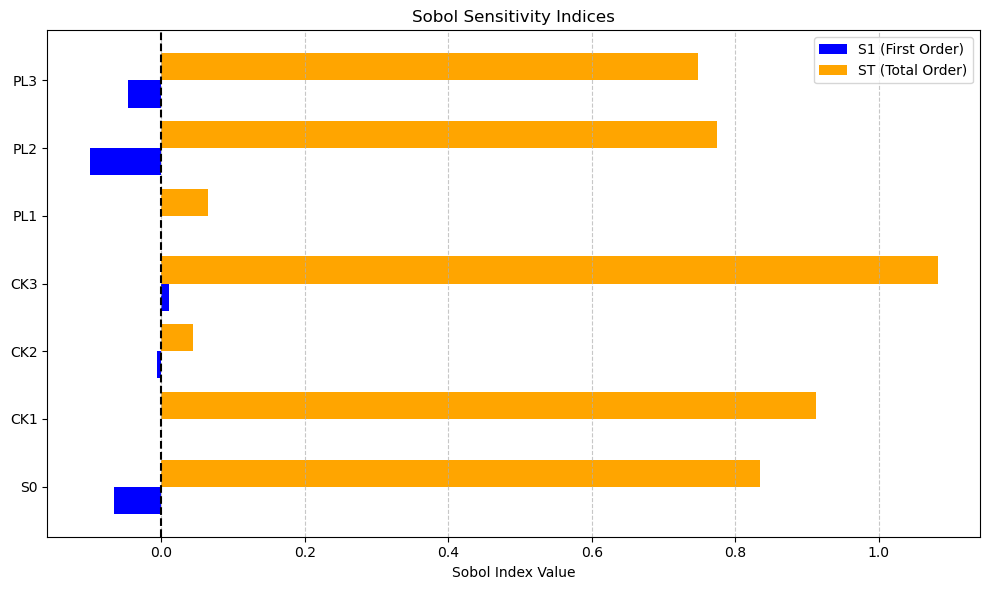

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
from scipy.optimize import linprog

# Ορισμός του μοντέλου (ο ίδιος όπως πριν)
def portfolio_model(params):
    S0, CK1, CK2, CK3, PL1, PL2, PL3 = params
    Y = 182
    strikes = [180, 190, 200]
    CK = [CK1, CK2, CK3]
    PL = [PL1, PL2, PL3]
    num_strikes = len(strikes)
    RatetoInf = 0.1

    num_vars = 2 + 2 * num_strikes + 1
    num_inequalities = 1 + num_strikes + 2 + 1

    b = np.zeros(num_inequalities)
    def vectors(x):
        call_terms = [-np.maximum(x - K, 0) for K in strikes]
        put_terms = [-np.maximum(L - x, 0) for L in strikes]
        return [-x, -1] + call_terms + put_terms + [-1]

    A = []
    x_values = [0] + strikes
    for x in x_values:
        A.append(vectors(x))

    A = np.array(A)
    A = np.vstack([A, np.array([0, -1] + [0] * (2 * num_strikes) + [0])])
    A = np.vstack([A, np.array([-1, 0] + [-1] * num_strikes + [0] * num_strikes + [0])])
    A = np.vstack([A, np.array([0] * (2 + 2 * num_strikes) + [-1])])

    b[:num_strikes + 1] = -Y
    b[num_strikes + 1] = 0
    b[num_strikes + 2] = -RatetoInf
    b[-1] = 100

    Aeq = np.zeros((1, num_vars))
    Aeq[0, 0] = S0
    Aeq[0, 1] = 1
    Aeq[0, 2:2 + len(CK)] = CK
    Aeq[0, 2 + len(CK):2 + len(CK) + len(PL)] = PL
    Aeq[0, -1] = 0

    beq = np.array([Y])
    f = np.zeros(num_vars)
    f[-1] = 1
    bounds = [(None, None), (None, None)] + [(None, None)] * num_strikes + [(None, None)] * num_strikes + [(None, None)]
    result = linprog(f, A, b, Aeq, beq, bounds, method='highs')
    
    if result.success:
        yy = result.x
        portfolio_value = yy[0] * S0 + yy[1] + np.sum(yy[2:2 + num_strikes] * np.array(CK)) + \
                          np.sum(yy[2 + num_strikes:2 + 2 * num_strikes] * np.array(PL))
        return portfolio_value
    else:
        return None

# SENSITIVITY ANALYSIS
problem = {
    'num_vars': 7,
    'names': ['S0', 'CK1', 'CK2', 'CK3', 'PL1', 'PL2', 'PL3'],
    'bounds': [[170, 190], [15, 17], [10, 14], [14, 16], [12, 14], [16, 18], [12, 14]]
}

# Δημιουργία δειγμάτων
param_values = saltelli.sample(problem, 1000)

# Υπολογισμός portfolio value
results = np.array([portfolio_model(params) for params in param_values])

# Αfairesi των nan
valid_results = results[~np.isnan(results)]

#total = len(results)
#valid = np.sum(~np.isnan(results))
#print(f"Valid results: {valid}/{total}") # tsekarw an exei diafora 


# Ανάλυση Sobol
Si = sobol.analyze(problem, valid_results)

# Εκτύπωση αποτελεσμάτων
print("First Order Indices:", Si['S1'])
print("Total Order Indices:", Si['ST'])

# Ραβδόγραμμα 
plt.figure(figsize=(10, 6))
indices = np.arange(len(problem['names']))
plt.barh(indices - 0.2, Si['S1'], height=0.4, label='S1 (First Order)', color='blue')
plt.barh(indices + 0.2, Si['ST'], height=0.4, label='ST (Total Order)', color='orange')
plt.yticks(indices, problem['names'])
plt.xlabel('Sobol Index Value')
plt.title('Sobol Sensitivity Indices')
plt.axvline(0, color='black', linestyle='--')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


